## Importing Packages
### Dependency
#### 1. bs4, nltk,  pandas, matplotlib, numpy, string required

In [1]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import xml.etree.ElementTree as ET 

## Extraction

In [2]:
# parsing xml to get the URL's

tree = ET.parse('mendeley_document_library_2020-03-25.xml') 
root = tree.getroot()

# urlList = [ url.text for url in root.iter('url')]
abstract = [ abstract.text for abstract in root.iter('abstract')]
# pdfUrl, httpUrl = [url for url in urlList if not url.startswith('http')], [url for url in urlList if url.startswith('http')]

random_state=42

In [3]:
df = pd.DataFrame(abstract, columns=['text'])
df.to_pickle("./df.pkl") # persisiting it for processing by other notebook

## Pre-Processing

In [4]:
# HTML tag removal
def remove_html(text):
    soup = BeautifulSoup(text, "lxml")
    return soup.get_text()

df['text'] = df['text'].apply(lambda x: remove_html(x))

# Punctuation removal
def remove_punctuation(text):
    return "".join([c for c in text if c not in string.punctuation])

df['text'] = df['text'].apply(lambda x: remove_punctuation(x))

# Tokenize text using spaces
tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

# Removing stopwords
def remove_stopwords(text):
    return [w for w in text if w not in stopwords.words('english')]

df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

# Lemmatizing the text
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    return" ".join( [lemmatizer.lemmatize(i) for i in text])

df['text'] = df['text'].apply(lambda x: word_lemmatizer(x))

## Model Building

In [5]:
# TFIDF Vectorizer
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.text.values)
features = vec.transform(df.text.values)

In [6]:
cls = MiniBatchKMeans(n_clusters=3, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [7]:
# predict cluster labels for new dataset
cls.predict(features)
cls.labels_

array([2, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 0, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2,
       2, 1, 2, 2, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 2,
       0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 0, 2, 2, 1, 1, 0, 1, 1, 1, 2,
       1, 0, 2, 1, 0, 1, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 2, 1, 2,
       2, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2,
       0, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1,
       2, 0, 1, 2, 2, 1, 2, 0, 2, 1, 2, 0, 1, 0, 0, 1, 1, 2, 2, 1, 0, 2,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 2, 0, 2, 0, 2, 0, 1,
       0, 1, 2, 2, 0, 0, 2, 2, 0, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0,
       1, 1, 1, 1, 0, 2, 0, 2, 2, 1, 0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1, 1,
       1, 1, 2, 0, 1, 1, 0, 0, 1, 2, 1, 2, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2,
       0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 1, 2, 1,

## Visualization

In [8]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

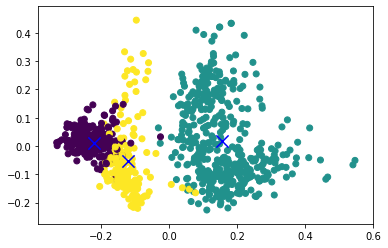

In [9]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

## Performance Evaluation

In [10]:
# measure performance for unlabelled dataset
silhouette_score(features, labels=cls.predict(features))

0.031745613368529886

## Persisting

In [11]:
dfLabels = pd.DataFrame(cls.labels_, columns = ['class'])

In [12]:
dfLabels.to_pickle("./dfLabels.pkl")